In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

from visualization_utils import confussion_pies

['mushroom-classification']


In [19]:
df=pd.read_csv("../input/mushroom-classification/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [20]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [21]:
df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [22]:
from sklearn import preprocessing
#Uncomment the next two lines for using label enconder on the dataset
#label_encoder = preprocessing.LabelEncoder()
#df = df.apply(label_encoder.fit_transform)

#Dummies
new_df = pd.DataFrame(df['class'])
for column in df.columns:
    if column != 'class':
        new_df = pd.concat([new_df, pd.get_dummies(df[column], prefix=column)],axis=1)

new_df['class'] = new_df['class'].map(lambda x : 1 if x == 'p' else 0)
df = new_df
# end of Dummies, comment these lines if you are using label encoders

df.head()

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_f,bruises_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,gill-color_e,...,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-type_p,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [23]:
'''correlation_matrix =  df.corr().round(2)
plt.figure(figsize=(20,20))
sns.heatmap(data=correlation_matrix, annot=True)'''

'correlation_matrix =  df.corr().round(2)\nplt.figure(figsize=(20,20))\nsns.heatmap(data=correlation_matrix, annot=True)'

In [24]:
from sklearn.model_selection import train_test_split

X = df.drop(['class'], axis=1)
y = pd.DataFrame(df['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred  = clf.predict(X_test)


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


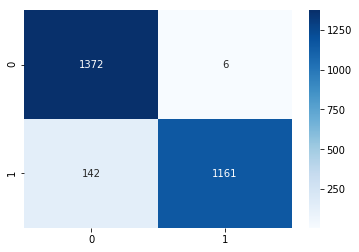

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(data=cm, annot=True, cmap='Blues', fmt='g')

In [26]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.94


In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                         Specs        Score
27                      odor_n  2836.187954
24                      odor_f  2321.062308
57  stalk-surface-above-ring_k  1986.408494
61  stalk-surface-below-ring_k  1914.371389
37                gill-color_b  1856.849847
36                 gill-size_n  1636.606833
96         spore-print-color_h  1560.187561
92                 ring-type_l  1392.637385
94                 ring-type_p  1213.995219
21                   bruises_t  1194.277352


In [28]:
good_features = featureScores.nlargest(12,'Score').Specs.tolist()

best_X_train = X_train[good_features]
best_X_test = X_test[good_features]

Score : 0.9219180598934411
Average precision-recall score: 0.89


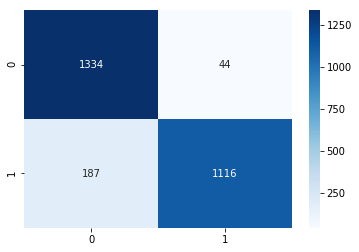

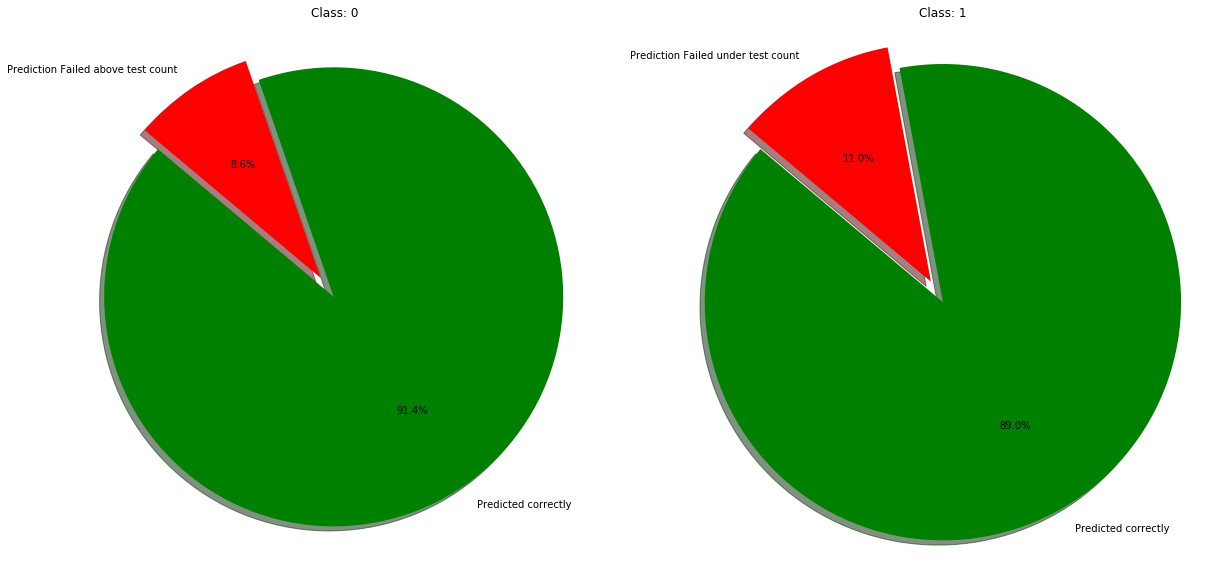

In [29]:
best_clf = MultinomialNB()
best_clf.fit(best_X_train, y_train.values.ravel())
print('Score : ' + str(best_clf.score(best_X_train, y_train.values.ravel())))

best_y_pred  = best_clf.predict(best_X_test)

average_precision = average_precision_score(y_test, best_y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

cm = confusion_matrix(y_test, best_y_pred)
sns.heatmap(data=cm, annot=True, cmap='Blues', fmt='g')

confussion_pies(y_test['class'], best_y_pred)

Score : 0.9300018372221202
Average precision-recall score: 0.91


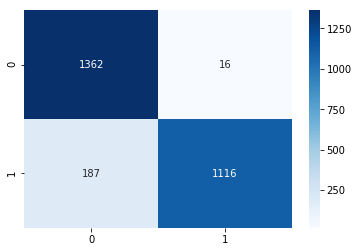

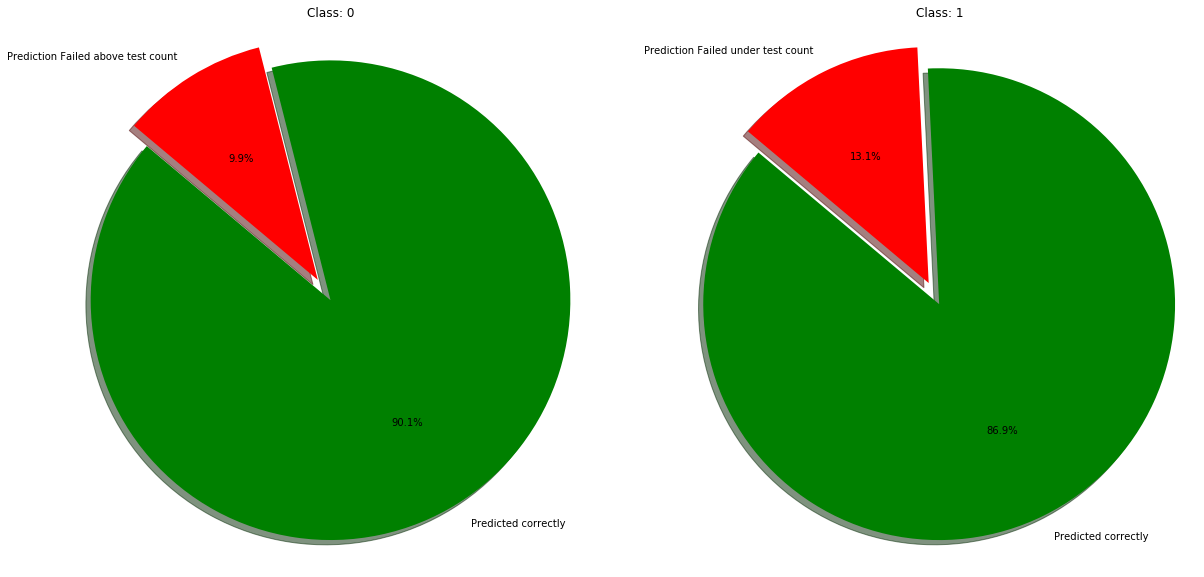

In [30]:
from sklearn.naive_bayes import BernoulliNB
bernoulli = BernoulliNB()
bernoulli.fit(best_X_train, y_train.values.ravel())
print('Score : ' + str(bernoulli.score(best_X_train, y_train.values.ravel())))

bernoulli_y_pred  = bernoulli.predict(best_X_test)

average_precision = average_precision_score(y_test, bernoulli_y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

cm = confusion_matrix(y_test, bernoulli_y_pred)
sns.heatmap(data=cm, annot=True, cmap='Blues', fmt='g')

confussion_pies(y_test['class'], bernoulli_y_pred)

Score : 0.935880948006614
Average precision-recall score: 0.93


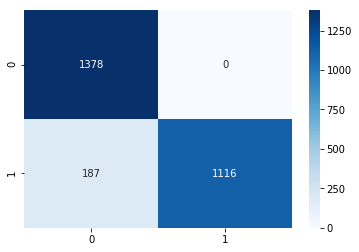

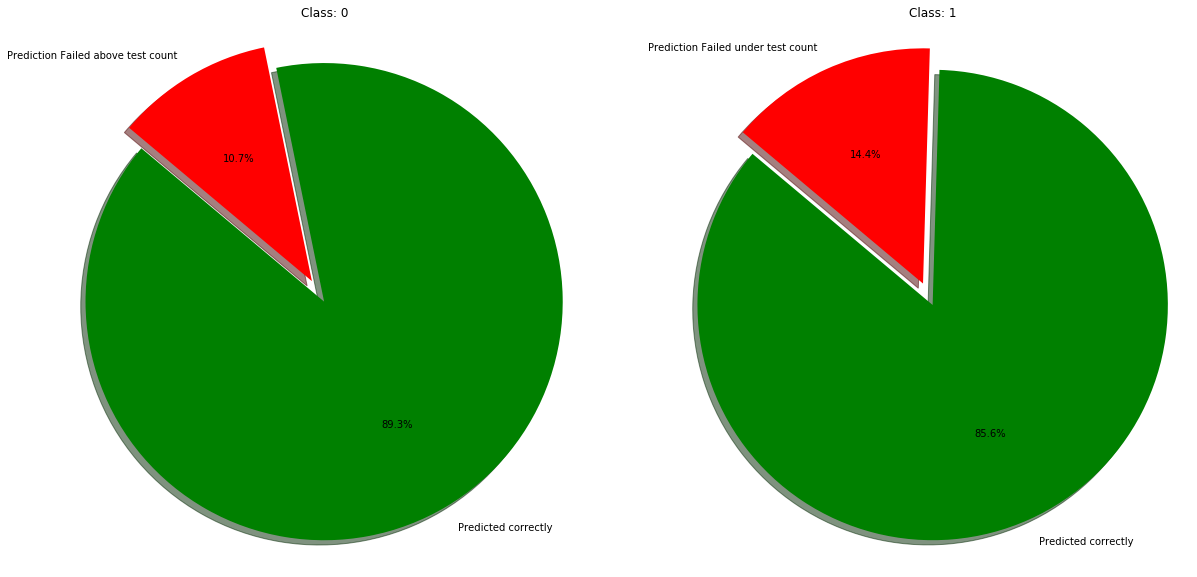

In [31]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=4, max_depth=2,
                             random_state=0)
random_forest.fit(best_X_train, y_train.values.ravel())
print('Score : ' + str(random_forest.score(best_X_train, y_train.values.ravel())))

rf_y_pred  = random_forest.predict(best_X_test)

average_precision = average_precision_score(y_test, rf_y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

cm = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(data=cm, annot=True, cmap='Blues', fmt='g')

confussion_pies(y_test['class'], rf_y_pred)

Score : 0.9893441117031049
Average precision-recall score: 0.93


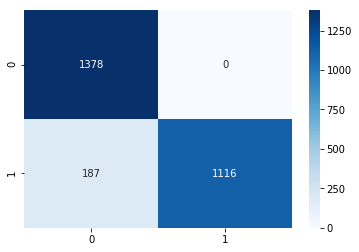

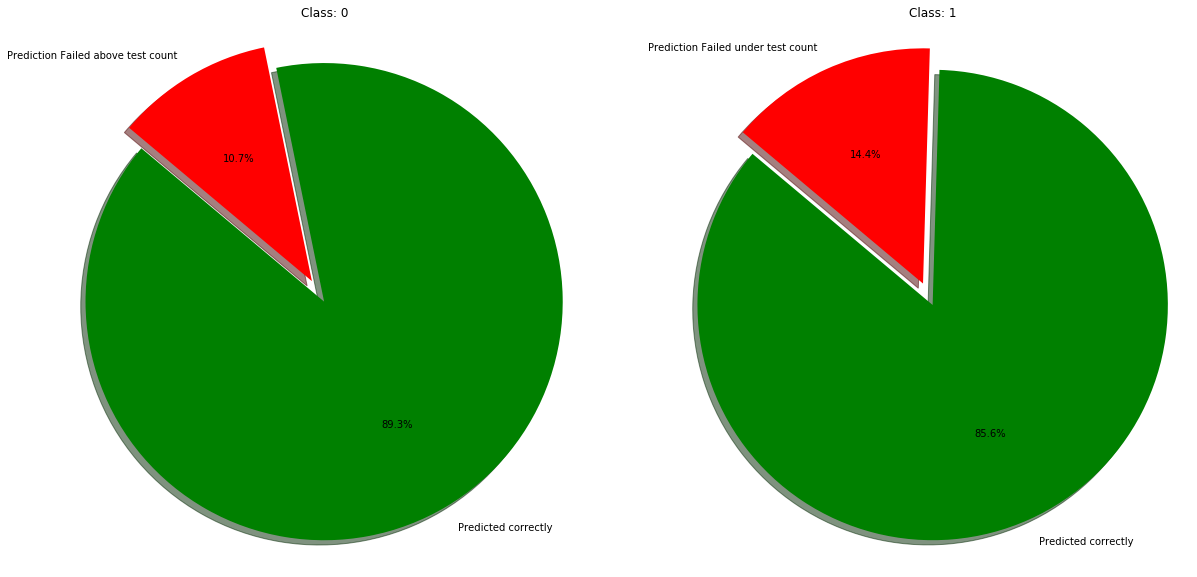

In [32]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(gamma="scale")
gs_svc = GridSearchCV(svc, parameters, cv=5)
gs_svc.fit(best_X_train,  y_train.values.ravel())
print('Score : ' + str(gs_svc.score(best_X_train, y_train.values.ravel())))

gs_svc_pred  = random_forest.predict(best_X_test)
average_precision = average_precision_score(y_test, gs_svc_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

cm = confusion_matrix(y_test, gs_svc_pred)
sns.heatmap(data=cm, annot=True, cmap='Blues', fmt='g')

confussion_pies(y_test['class'], gs_svc_pred)